# Blog Post 2: Spectral Clustering

## Introduction to Spectral Clustering & KMeans

In this blog post, we will construct the **spectral clustering** algorithm. **Spectral clustering** is a technique that makes use of the eigenvalues of the similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. In spectral clustering, the data points are treated as nodes of a graph and clusters are found by partitioning this graph based on its *spectral decomposition* (decomposing a matrix in terms of it eignevalues and eigenvectors) into subgraphs. Before implementing spectral clustering, we will start with an example in which the algorithm is not necessary.

In [226]:
# importing packages that will be necessary throughout the blog post
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from scipy.optimize import minimize

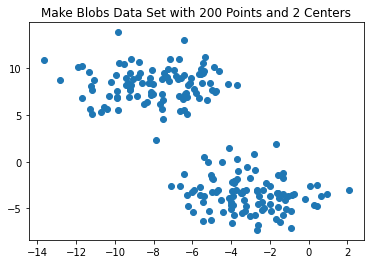

In [227]:
# number of data points
n = 200

# setting the seed so that we get similar data everytime
np.random.seed(1111)

# creating a scatterplot of the make blobs data
X, y = datasets.make_blobs(n_samples=n, shuffle=True, random_state=None, centers = 2, cluster_std = 2.0)
plt.scatter(X[:,0], X[:,1])
plt.title(f"Make Blobs Data Set with {n} Points and 2 Centers");

We observe that the data above is pretty well clustered on its own. This implies that we don't need fancy clustering algorithms to separate the data into their own clusters. Instead, we can use an algorithm like **KMeans** to do the work for us.

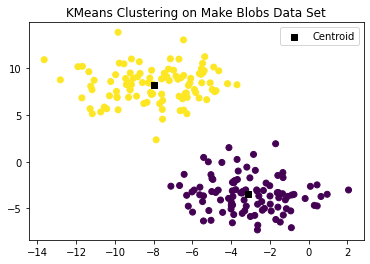

In [228]:
# creating a KMeans model with two clusters
km = KMeans(n_clusters = 2)

# fitting the KMeans model to the data
km.fit(X)

# creating a scatterplot that shows how KMeans clusters the data 
plt.scatter(X[:,0], X[:,1], c = km.predict(X))
plt.title("KMeans Clustering on Make Blobs Data Set")

# getting centroid coordinates 
cluster_coords = km.cluster_centers_

# plotting centroids on scatterplot
plt.scatter(cluster_coords[0,0], cluster_coords[0,1], c = 'black', marker = 's', label = "Centroid")
plt.scatter(cluster_coords[1,0], cluster_coords[1,1], c = 'black', marker = 's')
plt.legend(loc = 'best');

In the above code block we have clustered the make blobs data set using the **KMeans** clustering algorithm. The KMeans algorithm identifies k number of centroids and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. We now will look at a data set in which the data isn't as definitively clustered as the make blobs data. Instead we will have two "crescent" shaped clusters and test how the same KMeans algorithm works on this data set.

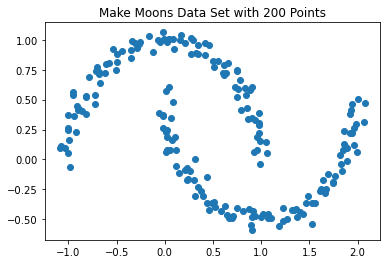

In [229]:
# setting the seed so that we get similar data everytime
np.random.seed(1234)

# number of data points
n = 200

# creating fake data that does not have definitive clusters
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.05, random_state=None)

# plotting the data
plt.scatter(X[:,0], X[:,1])
plt.title(f"Make Moons Data Set with {n} Points");

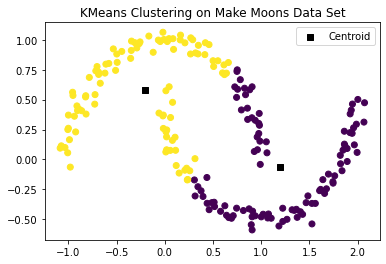

In [230]:
# running KMeans on the data and coloring the data based on KMeans clusters
km = KMeans(n_clusters = 2)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c = km.predict(X))
plt.title("KMeans Clustering on Make Moons Data Set")

# getting centroid coordinates 
cluster_coords = km.cluster_centers_

# plotting centroids on scatterplot
plt.scatter(cluster_coords[0,0], cluster_coords[0,1], c = 'black', marker = 's', label = "Centroid")
plt.scatter(cluster_coords[1,0], cluster_coords[1,1], c = 'black', marker = 's')
plt.legend(loc = 'best');

We see that the KMeans algorithm does not correctly classify the two moon shaped data. This is because the algorithm identifies the two black points as centroids and picks the points nearest to each respective centroid. Thus by the manner in which KMeans works, the algorithm will not correctly classify the two moons correctly. Hence we need to try another method (spectral clustering) in order to correctly classfiy the two moon data groups. We now begin deriving/implementing this new algorithm step by step.

## Part A: Similarity Matrix

The first step involved in implementing the spectral clustering algorithm requires us to construct the *similarity matrix*, a matrix in which the elements measure pairwise similarities of objects. We denote the similarity matrix $\mathbf{A}$ to be of size **n x n** where n is the number of data points. When constructing the similarity matrix we use a parameter **epsilon** which measures the distance between point `X[i]` and `X[j]`. Entry `A[i,j]` will be equal to `1` if `X[i]` (the coordinates of data point `i`) is within distance epsilon of `X[j]` (the coordinates of data point `j`) and `0` otherwise. Additionally, the diagonal entries `A[i,i]` should all be equal to `0` since the distance between the points `X[i]` and `X[i]` is `0`. We now construct the similarity matrix using `epsilon = 0.4`. 

In [180]:
def similarity_matrix(X,epsilon):
    
    # defining a matrix A which will contain the distances between the points in the input matrix
    A = pairwise_distances(X, metric = 'euclidean')
    
    # if points are within a distance epsilon, then we mark those as a 1, else the points are labeled as 0
    A = (A < epsilon).astype(int)
    
    # filling the diagonal with 0
    np.fill_diagonal(A, 0)
    
    # returning similarity matrix
    return A

# creating the similarity matrix through a function call
A = similarity_matrix(X,0.4) 
A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

## Part B: Computing Cut, Volume, and Normcut

Now that we have our similarity matrix which contains information about which points are within `epsilon` distance of each other, we now move on to the task of clustering the data points in the matrix `X` which can be considered the same as partioning the rows and columns of the matrix `A` (recall in the introduction that we mentioned that we partition based on the spectral decomposition however we will get to that later). Before defining the terms cut, volume, and normcut, we first give some preliminary background. We let $C_0$ and $C_1$ be two clusters of the data points and assume that every data point in $\mathbf{A}$ is in either $C_0$ or $C_1$ (the cluster membership is denoted by the vector `y` which we defined in the `Introduction`. If `y[i] = 1`, then point `i` (and therefore row $i$ of $\mathbf{A}$) is an element of cluster $C_1$ and if `y[i] = 0`, then point `i` (and therefore row $i$ of $\mathbf{A}$) is an element of cluster $C_0$.

We will now focus on computing the cut, volume, and normcut. The **definitions and equations** for these concepts are:

$\mathbf{cut}(C_0, C_1)$ is the number of nonzero entries in $\mathbf{A}$ that relate points in cluster $C_0$ to points in cluster $C_1$.  

$\mathbf{cut}(C_0, C_1) \equiv \sum_{i \in C_0, j \in C_1} a_{ij}$ is the *cut* of the clusters $C_0$ and $C_1$.

The **volume** of a cluster $C_0$ is a measure of the size of the cluster. 

$\mathbf{vol}(C_0) \equiv \sum_{i \in C_0}d_i$, where $d_i = \sum_{j = 1}^n a_{ij}$ is the *degree* of row $i$ (the total number of all other rows related to row $i$ through $A$)

The **binary norm cut objective** of a matrix $\mathbf{A}$ is the function 

$$N_{\mathbf{A}}(C_0, C_1)\equiv \mathbf{cut}(C_0, C_1)\left(\frac{1}{\mathbf{vol}(C_0)} + \frac{1}{\mathbf{vol}(C_1)}\right)\;.$$

### Part B1: The Cut Term

In [181]:
def cut(A,y):
    
    # c represents the cut value which will be computed within this function
    c = 0
    
    # double for loop which loops through all rows and columns of A
    for i in range(0,y.shape[0]): 
        for j in range(0,y.shape[0]):
            
            # checks if a pair of points (i,j) are in different clusters (if so then we add the respective entry in the matrix A to the cut value c)
            if (y[i] != y[j]):
                c += A[i,j]
                
    # returning the cut value           
    return c

# outputing the value computed from our cut function
cut(A,y)

26

We have found that the cut of the matrix $\mathbf{A}$ is denoted by the value `26`. This means that `26` entries in $\mathbf{A}$ relate points in cluster $C_0$ to points in cluster $C_1$. We will now show that the cut objective favors the true clusters over the random ones. To do so we will generate a random vector of random labels of length `n`, with each label equal to either `0` or `1` and compare the cut objective of this random vector to the cut objective of the true labels. We should expect to find that the the cut objective for the true labels is *much* smaller than the cut objective for the random labels. This is because the similarity matrix $\mathbf{A}$ depends on the vector `X` which also has some dependence on the true labels `y`. 

In [32]:
# cut_true represents the cut objective value for the true clusters y
cut_true = cut(A,y)

# creating a random vector of size n that contains 0 or 1
random_vector = np.random.randint(2,size = n)

# cut_random represents the cut objective value for the random labels
cut_random = cut(A, random_vector)

# comparing the cut objective for the true vs random labels
print("Cut True:", cut_true, "\nCut Random:", cut_random)

Cut True: 26 
Cut Random: 2228


Our hypothesis was correct! The true cut objective is in fact much smaller than the random cut objective for the reasons mentioned above. We now move on to computing the volume term.

### Part B2: The Volume and Normcut Term

As we stated earlier the **volume** of cluster $C_0$ is a measure of the size of the cluster and is denoted by the formula:

$\mathbf{vol}(C_0) \equiv \sum_{i \in C_0}d_i$, where $d_i = \sum_{j = 1}^n a_{ij}$ is the *degree* of row $i$ (the total number of all other rows related to row $i$ through $A$)

We can compute this term by first calculating the vector `d` where each entry will contain the row sums of the matrix $\mathbf{A}$ and then use the resulting vector to compute the volume.

In [185]:
def vols(A,y):
    
    # returning sum of elements in A that belong to each respective label in y
    return np.sum(A[y == 0], axis = None), np.sum(A[y == 1], axis = None)

We now focus on computing the **normcut** objective which we recall is given by:

$$N_{\mathbf{A}}(C_0, C_1)\equiv \mathbf{cut}(C_0, C_1)\left(\frac{1}{\mathbf{vol}(C_0)} + \frac{1}{\mathbf{vol}(C_1)}\right)\;.$$

We can combine the use of our `cut` and `vols` function to compute the normcut.

In [183]:
def normcut(A,y):
    
    # getting the volume for each cluster by calling the function vols which we created above
    v0, v1 = vols(A,y)
    
    # returning the normcut objective value 
    return cut(A,y) * (1/v0 + 1/v1)

We now want to compare the `normcut` objective using both the true labels from `y` and the fake labels. Similar to when we compared the `cut` of the true and fake labels, we expect to see that the `normcut` for the true labels is much smaller than for the fake labels. 

In [186]:
# comparing the normcut value for true label vs fake labels
print("Normcut for true labels:", normcut(A,y), "\nNormcut for fake labels:", normcut(A,random_vector))

Normcut for true labels: 0.02303682466323045 
Normcut for fake labels: 2.040033251556132


## Part C: The Transform Function

Now that we have computed the normcut objective, we want to focus on the clustering portion of the spectral clustering algorithm. One way to approach this problem is to try to find a cluster vector `y` such that `normcut(A,y)` is small, however this a difficult optimization problem to solve that may not be solvable in a reasonable amount of time. Instead we introduce the vector $\mathbf{z} \in \mathbb{R}^n$ such that:

$$
z_i = 
\begin{cases}
    \frac{1}{\mathbf{vol}(C_0)} &\quad \text{if } y_i = 0 \\ 
    -\frac{1}{\mathbf{vol}(C_1)} &\quad \text{if } y_i = 1 \\ 
\end{cases}
$$

Thus with this defintion, it can be proved using linear algebra that the $N_{\mathbf{A}}(C_0, C_1)$ equation from part B can be rewritten as:

$$\mathbf{N}_{\mathbf{A}}(C_0, C_1) = 2\frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}}\;,$$

where $\mathbf{D}$ is the diagonal matrix with nonzero entries $d_{ii} = d_i$, and  where $d_i = \sum_{j = 1}^n a_i$ is the degree (row-sum) from before.  

We will first write a function called `transform(A,y)` to compute the $\mathbf{z}$ vector given `A` and `y`, using the formula above. 

In [188]:
def transform(A,y):
    
    # computing the volumes for each respective cluster using our vols function from above
    v0,v1 = vols(A,y)
    
    
    # creating a n x 1 vector of zeros
    z = np.zeros(n)
    
    # for entries in the vector y that have a 0, for that same entry in z we assign it to the volume of cluster 0
    z[y == 0] = v0
    
     # for entries in the vector y that have a 1, for that same entry in z we assign it to the negative volume of cluster 1
    z[y == 1] = -v1
    
    # taking the inverse of each element in z
    return np.array([1/z]).T

We now want to check the equivalence of the $\mathbf{N}_{\mathbf{A}}(C_0, C_1)$ equation and show that the defintion we have given above is equal to the formula we gave in `Part B`. We will compute each separately and check if they are equal using the `np.isclose()` function. 

In [189]:
# creating an n x n matrix D which contains all zeros
D = np.zeros((n,n))

# filling the diagonal matrix D where the ith entry contains the ith row sum of A 
np.fill_diagonal(D, A.sum(axis = 1))

# getting the z vector from our transform function
z = transform(A,y)

# checking the equivalence of the 2 normcut objective formulas
np.isclose(normcut(A,y), 2 * (z.T @ (D - A) @ z)/(z.T @ D @ z))[0,0]

True

We see from the above result that we get a boolean value of `True`, hence we can confirm that the two formula definitions are equivalent. As another confirmation that our work so far has been done correctly, we will also check the identity $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$, where $\mathbb{1}$ is the vector of `n` ones (i.e. `np.ones(n)`). This identity essentially shows that $\mathbf{z}$ contains roughly as many positive as negative entries. We will once again use the `np.isclose()` function.

In [190]:
# checking that the above identity holds and is equal to 0
np.isclose(z.T @ D @ np.ones(n),0)[0]

True

We once again get a boolean value of `True`, hence we can confirm that the identity holds. 

## Part D: Optimizing Orthogonal Objective

In this step of the tutorial we will focus on using optimization techniques to minimize the normcut objective. In `Part C` we found that minimizing the normcut objective is mathematically related to the problem of minimizing the function 

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$
subject to the condition $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$

To begin we first start by constructing $ R_\mathbf{A}(\mathbf{z})$

In [50]:
# computes the orthogonal projection between 2 vectors
def orth(u, v):
    return (u @ v) / (v @ v)*v

e = np.ones(n) 

d = D @ e

# computes the orthogonal objective
def orth_obj(z):
    z_o = z - orth(z, d)
    return (z_o @ (D - A) @ z_o)/(z_o @ D @ z_o)

We will now use the `scipy.optimize` function to minimize the function `orth_obj` with respect to $\mathbf{z}$. We will assign this to the minimizer `z_` of the `orth_obj` function with respect to $\mathbf{z}$.

In [52]:
# using the minimize function to minimize the function orth_obj with respect to z
z_ = minimize(orth_obj, z)

In the above cell we have minimzed an *approximation* of the normcut objective, not the actual normcut objective. This tactic is called the *continuous relaxation* of the normcut problem. 

## Part E: Testing on Make Moons Data

In this section of the tutorial, we will now apply the work we have done in `Part D` to the make moons data set we created back in `Part A`. By our work above, only the sign of `z_min[i]` actually contains information about the cluster label of data point `i`. So we will once again plot the make moons data this time coloring based on the sign of `z_min[i]` to see how well we can classify the two crescent moons. 

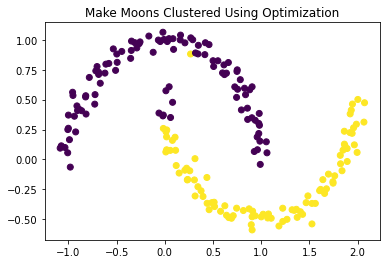

In [65]:
# z_min is a numpy array and is the minimizer with respect to z
z_min = z_.x

# plotting the original data using purple for points such that z_min[i] < -0.0015 and yellow otherwise
plt.scatter(X[:,0], X[:,1], c = z_min < -0.0015)
plt.title("Make Moons Clustered Using Optimization");

We see that this selection of `z_min[i] < -0.0015` does a pretty good job of classifying the two moons! However, there is a much more efficient way of implementing this algorithm rather than optimizing the orthogonal objective. We will explore this *other* method in the next part.

## Part F: Applying the *Spectral* to Spectral Clustering

As noted in the definition of spectral clustering in the `Introduction`, we said that the algorithm utilizes the *spectral decomposition* (decomposing a matrix in terms of it eigenvalues and eigenvectors). Rather than using optimization as we did in `Part E`, we can use the eigenvalues and eigenvectors of a matrix to perform spectral clustering. We recall that we are trying to minimize the function:

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$
subject to the condition $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$

We can apply the Rayleigh-Ritz Theorem which states that the minimizer $\mathbf{z}$ must be the solution with smallest eigenvalue of the generalized eigenvalue problem 

$$ (\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{D}\mathbf{z}\;, \quad \mathbf{z}^T\mathbf{D}\mathbb{1} = 0$$

which is equivalent to the standard eigenvalue problem 

$$ \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{z}\;, \quad \mathbf{z}^T\mathbb{1} = 0\;.$$

We know that $\mathbb{1}$ is the eigenvector with smallest eigenvalue of the matrix $\mathbf{D}^{-1}(\mathbf{D} - \mathbf{A})$ so that means the vector $\mathbf{z}$ is the eigenvector with the *second*-smallest eigenvalue. 

We now focus on constructing the matrix $\mathbf{L} = \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A})$, which is called the *Laplacian* of the similarity matrix $\mathbf{A}$. Next we will find the second smallest eigenvalue and then replot the make moons data set this time coloring by the *sign* of the eigenvalue.

In [200]:
# constructing the Laplacian of the similarity matrix A
L = np.linalg.inv(D) @ (D - A)

# unpacking the eigenvalues and eigenvectors from the matrix L
Lam,U = np.linalg.eig(L)

# sorting the eigenvalues
ix = Lam.argsort()

# sorting by column
Lam, U = Lam[ix], U[:,ix]

# getting the eigenvector corresponding to the 2nd smallest eigenvalue
z_eig = U[:,1]

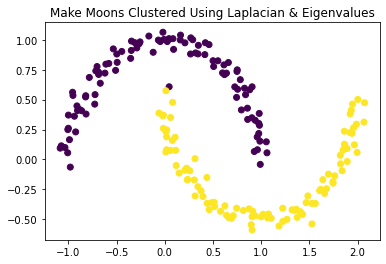

In [191]:
# plotting the original data and using the sign of z_eig as the color
plt.scatter(X[:,0], X[:,1], c = z_eig < 0)
plt.title("Make Moons Clustered Using Laplacian & Eigenvalues");

We see that this method of using the Laplacian and its eigenvalues/vectors had identical accuracy to its optimization counterpart but is even more efficient! We can now combine all of the work we have done to get to this point into a single concise and compact function. 

## Part G: Spectral Clustering Function

We are now going to create a function called `spectral_clustering(X,epsilon)` which performs spectral clustering and returns an array of binary labels indicating whether data point `i` is in group `0` or group `1`. We will use some of the code that we have written in `Parts A - F`.

In [112]:
def spectral_clustering(X, epsilon): 
    
    '''
    Takes in the input data X and the distance threshold epsilon and performs spectral clustering. 
    Returns an array of binary labels indicating whether data point i is in group 0 or group 1. The 
    function works in the following way:
    
    1. Constructs the similarity matrix
    2. Constructs the Laplacian matrix
    3. Computes the eigenvector with second-smallest eigenvalue of the Laplacian matrix 
    4. Returns labels based on this eigenvector
    
    '''
    
    # construct the similarity matrix using our function from Part A
    A = similarity_matrix(X,epsilon)
    
    D = np.zeros((X.shape[0], X.shape[0]))

    # filling the diagonal matrix D which contains the ith row sum of A in the ith diagonal entry
    np.fill_diagonal(D, A.sum(axis = 1))
    
    # constructing the Laplacian matrix
    laplacian = np.linalg.inv(D) @ (D - A)
    
    # unpacking the eigenvalues and eigenvectors from the Laplacian 
    Lam,U = np.linalg.eig(laplacian)
    
    # sorting the eigenvalues
    ix = Lam.argsort()

    # sort by column
    Lam, U = Lam[ix], U[:,ix]

    # getting the 2nd smallest eigenvalue and corresponding eigenvector
    z_eig = U[:,1]
    
    # returning a boolean array of labels
    return z_eig < 0

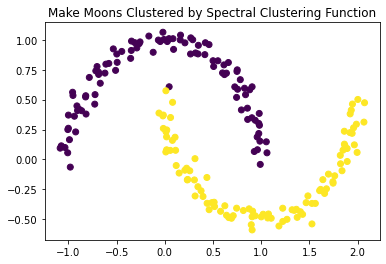

In [113]:
# plotting the data with the coloring specified by the spectral clustering algorithm
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,epsilon = 0.4))
plt.title("Make Moons Clustered by Spectral Clustering Function");

After creating our spectral clustering function and plotting the data, we see that we have obtained the same results as `Part F`, so we can conclude that we were successful in synthesizing our work into a single function. In the next and penultimate part of this blog, we will perform this algorithm on the same data set but with different parameters.

## Part H: Experimenting with Spectral Clustering

We now want to test our newly created spectral clustering algorithm and see how it performs on the same make moons data set but with different values of `n` and `noise`. We are essentially checking if spectral clustering still has the ability to find the two half-moon clusters and correctly classify them for other test cases.

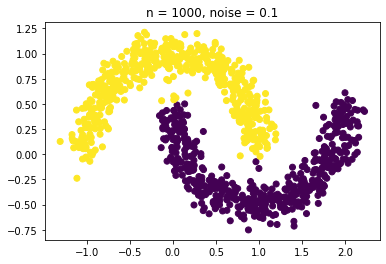

In [119]:
# changing n value
n = 1000

# setting the seed so that our random data is consistent
np.random.seed(1111)

# making new moons data set with n_samples = 1000 and noise = 0.1
X, y = datasets.make_moons(n_samples = n, shuffle = True, noise = 0.1, random_state = None)

# plotting the data
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,epsilon = 0.4));
plt.title("n = 1000, noise = 0.1");

**n = 1000, noise = 0.1**: We see that for more noise and data points, our spectral clustering algorithm still does a good job of finding the two half moon clusters. There are a few points in the plot that might be wrongly classified, however for the most part our algorithm does a good job for this case.

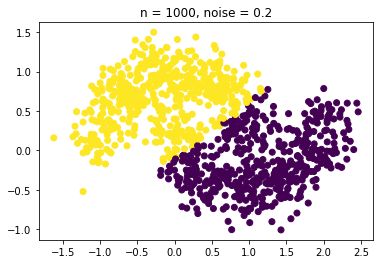

In [120]:
# setting the seed so that our random data is consistent
np.random.seed(1111)

# making new moons data set with n_samples = 1000 and noise = 0.2
X, y = datasets.make_moons(n_samples = n, shuffle = True, noise = 0.2, random_state = None)

# plotting the data
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,epsilon = 0.4));
plt.title("n = 1000, noise = 0.2");

**n = 1000, noise = 0.2**: For this case, the crescent moon shapes are distored due to the increase in the noise. However once again we see that our spectral clustering is successful in splitting the data into two clusters.

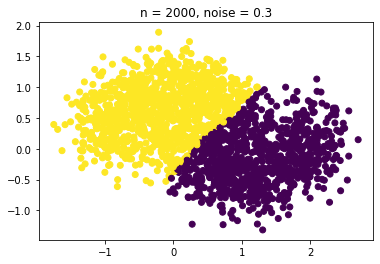

In [122]:
# changing n value
n = 2000

# setting the seed so that our random data is consistent
np.random.seed(1111)

# making new moons data set with n_samples = 2000 and noise = 0.3
X, y = datasets.make_moons(n_samples = n, shuffle = True, noise = 0.3, random_state = None)

# plotting the data
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,epsilon = 0.4));
plt.title("n = 2000, noise = 0.3");

**n = 2000, noise = 0.3**: A further increase in the noise along with a slight increase in the number of data points demonstrates that our clustering algorithm is still efficient in finding two clusters.

## Part I: Spectral Clustering on Bullseye

In the last part of this tutorial we will now run our spectral clustering function on the make circles data set to see how the work we have done can be extended to other data sets. Prior to testing on the `spectral_clustering(X,epsilon)` function we will first visualize the data and then see how successful **KMeans** is in classifying the clusters.

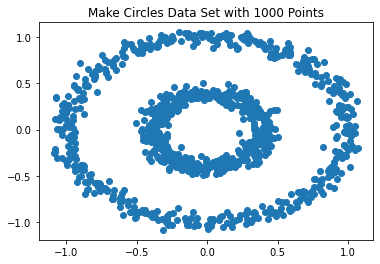

In [202]:
# assigning n
n = 1000

# plotting the make circles data set
X, y = datasets.make_circles(n_samples = n, shuffle = True, noise = 0.05, random_state = None, factor = 0.4)
plt.scatter(X[:,0], X[:,1])
plt.title(f"Make Circles Data Set with {n} Points");

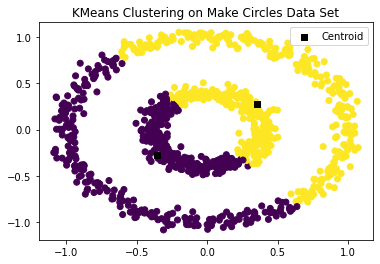

In [203]:
# fitting KMeans to this new data set
km = KMeans(n_clusters = 2)
km.fit(X)

# plotting the data and coloring by KMeans
plt.scatter(X[:,0], X[:,1], c = km.predict(X))
plt.title("KMeans Clustering on Make Circles Data Set")

# getting centroid coordinates 
cluster_coords = km.cluster_centers_

# plotting centroids on scatterplot
plt.scatter(cluster_coords[0,0], cluster_coords[0,1], c = 'black', marker = 's', label = "Centroid")
plt.scatter(cluster_coords[1,0], cluster_coords[1,1], c = 'black', marker = 's')
plt.legend(loc = 'best');

We observe that once again KMeans is not able to correctly cluster the two groups correctly. We can see what goes wrong by looking at the centroids which are computed when we fit the data to KMeans. The centroids plotted suggest that KMeans is grouping points based on which points are closest to one of the respective centroids. Hence by this reasoning KMeans does not do a good job of clustering each circle separately.

We will now test if the spectral clustering function that we created can successfully distinguish between the two circles. We will test how it works for varying `epsilon` values between `0` and `1` to see if we get varying differences in the plots.  

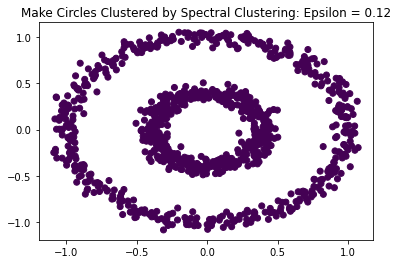

In [204]:
# executing the clustering algorithm for epsilon = 0.12 on the new data set
np.random.seed(1111)
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,epsilon = 0.12))
plt.title("Make Circles Clustered by Spectral Clustering: Epsilon = 0.12");

**Epsilon = 0.12**: We observe that for this epsilon value, the spectral clustering algorithm only classifies all the points as belonging to a single group. This implies that all of the Euclidean distances between the points in the matrix `X` are a greater distance apart than `0.12`, hence all of the data points will belong to a single group. 

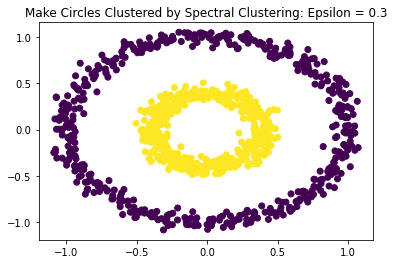

In [219]:
# executing the clustering algorithm for epsilon = 0.2 on the new data set
np.random.seed(1111)
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,epsilon = 0.3))
plt.title("Make Circles Clustered by Spectral Clustering: Epsilon = 0.3");

**Epsilon = 0.3**: Our clustering algorithm classifies the inner circle as yellow and the outer circle as purple. This shows that our algorithm was able to distinguish between the two circles which is what we wanted to achieve!

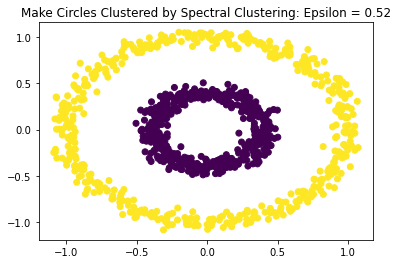

In [220]:
# executing the clustering algorithm for epsilon = 0.4 on the new data set
np.random.seed(1111)
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,epsilon = 0.52))
plt.title("Make Circles Clustered by Spectral Clustering: Epsilon = 0.52");

**Epsilon = 0.52**: Our clustering algorithm classifies the inner circle as purple and the outer circle as yellow. This is the opposite of what we observed in the above case however we were still able to correctly distinguish between the two groups, the only thing that swapped was the signs of the labels.

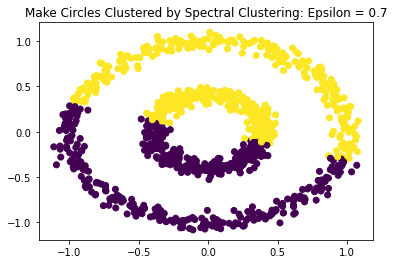

In [165]:
# executing the clustering algorithm for epsilon = 0.7 on the new data set
np.random.seed(1111)
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,epsilon = 0.7))
plt.title("Make Circles Clustered by Spectral Clustering: Epsilon = 0.7");

**Epsilon = 0.7**: For this epsilon value we see that the clustering algorithm does not do a good job of separating the different circles. This is because we have a greater tolerance of distance between the points, so points that are further apart might be classified in the same group. So we conclude that epsilon values roughly between `0.3` and `0.53`  is best for separating the two circles.